In [2]:
import itertools
import glob

import dask.dataframe as dd
import pandas as pd
import seaborn as sns
# import matplotlib.pyplot as plt
from gimmemotifs.motif import Motif, read_motifs
from gimmemotifs.fasta import Fasta
from gimmemotifs.scanner import Scanner
from nopeak_utils.nopeak import NoPeakMotif
from tfomics import ReferenceGenome

%matplotlib inline

/Users/oalmelid/anaconda3/envs/nopeak_utils/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fontconfig warning: ignoring UTF-8: not a valid region tag


In [3]:
all_motifs = list(itertools.chain.from_iterable(NoPeakMotif.from_file(infile, strip_edges=False) for infile in glob.glob("data/*.motifs.*")))
high_kmer_motifs = [motif for motif in all_motifs if int(motif.kmer_count) > 230]

In [4]:
len(high_kmer_motifs)

2

In [5]:
jaspar_motifs = read_motifs("jaspar/MA0139.1.jaspar", fmt="jaspar") #+ [m for m in read_motifs() if "CTCF" in m.factors['direct']]

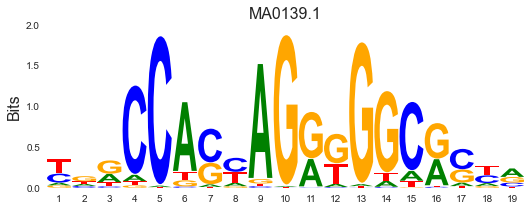

In [6]:
jaspar_motifs[0].plot_logo()

In [7]:
asb_data = dd.read_csv("asb/*.csv", include_path_column=True)
asb_data.head()

,ID,CHROM,POS,REF,ALT,REF.counts,ALT.counts,Total.counts,AR,RMbias,RAF,Bayes_lower,Bayes_upper,Bayes_SD,Corrected.AR,isASB,peak,path
0,rs1043897,chr1,230416399,G,T,6,2,8,0.750000,0.498905,0.670986,0.266662,0.814342,0.143168,0.540502,False,True,/Users/oalmelid/src/prototypes/motifs/asb/A549...
1,rs10494924,chr1,209527706,T,G,38,43,81,0.469136,0.507349,0.413892,0.452832,0.655640,0.052384,0.554236,False,True,/Users/oalmelid/src/prototypes/motifs/asb/A549...
2,rs1061511,chr1,160189500,C,A,80,62,142,0.563380,0.536405,0.599027,0.387567,0.544682,0.040788,0.466124,False,True,/Users/oalmelid/src/prototypes/motifs/asb/A549...
3,rs10800374,chr1,168606715,G,A,9,32,41,0.219512,0.514544,0.347637,0.220050,0.527530,0.079390,0.373790,False,True,/Users/oalmelid/src/prototypes/motifs/asb/A549...
4,rs10911467,chr1,183885406,A,G,65,30,95,0.684211,0.496446,0.668285,0.422900,0.632446,0.053866,0.527673,False,True,/Users/oalmelid/src/prototypes/motifs/asb/A549...


In [19]:
old_asb_data = pd.read_csv("v1_ctcf_snps.csv")
old_asb_data = old_asb_data.rename(columns={"corrected_allelic_ratio" : "Corrected.AR", "pos" : "POS", "ref" : "REF", "alt": "ALT", "chrom" : "CHROM"})
old_asb_data.head()

,Unnamed: 0,id,cell_line,transcription_factor,report,snp,baal_group,ref_counts,alt_counts,total_counts,...,Corrected.AR,asb,rsid,CHROM,POS,REF,ALT,Start,End,Chromosome
0,0,153,A549,CTCF,/home/oyvind/work/nf_prototypes/reports_300/re...,rs2242194,153,75,41,116,...,0.759229,True,rs2242194,chr1,154990297,C,G,154990297,154990298,chr1
1,1,153,A549,CTCF,/home/oyvind/work/nf_prototypes/reports_300/re...,rs10172023,153,8,1,9,...,0.816133,True,rs10172023,chr2,152476028,C,G,152476028,152476029,chr2
2,2,153,A549,CTCF,/home/oyvind/work/nf_prototypes/reports_300/re...,rs1123648,153,62,6,68,...,0.893001,True,rs1123648,chr2,37232330,C,T,37232330,37232331,chr2
3,3,153,A549,CTCF,/home/oyvind/work/nf_prototypes/reports_300/re...,rs1169252,153,12,1,13,...,0.849583,True,rs1169252,chr2,35261253,G,A,35261253,35261254,chr2
4,4,153,A549,CTCF,/home/oyvind/work/nf_prototypes/reports_300/re...,rs12617169,153,15,3,18,...,0.780545,True,rs12617169,chr2,12307810,C,T,12307810,12307811,chr2


In [9]:
asb_sites = asb_data[asb_data.isASB].compute()

In [16]:
genome = ReferenceGenome("genome/hg19.fa.bz2")
genome.offset = 25

In [17]:
asb_peak_sites = asb_sites[asb_sites.peak].reset_index(drop=True)
asb_peak_sites.head()

,ID,CHROM,POS,REF,ALT,REF.counts,ALT.counts,Total.counts,AR,RMbias,RAF,Bayes_lower,Bayes_upper,Bayes_SD,Corrected.AR,isASB,peak,path
0,rs12029054,chr1,249121038,A,C,4,43,47,0.085106,0.487625,0.384988,0.071294,0.296318,0.058421,0.183806,True,True,/Users/oalmelid/src/prototypes/motifs/asb/A549...
1,rs16841877,chr1,241774286,C,T,67,10,77,0.870130,0.515703,0.675301,0.619430,0.851758,0.059769,0.735594,True,True,/Users/oalmelid/src/prototypes/motifs/asb/A549...
2,rs2000319,chr1,223885843,G,A,5,39,44,0.113636,0.514544,0.355200,0.107990,0.376687,0.070509,0.242339,True,True,/Users/oalmelid/src/prototypes/motifs/asb/A549...
3,rs2242194,chr1,154990297,C,G,229,130,359,0.637883,0.479728,0.355978,0.714388,0.800535,0.021400,0.757461,True,True,/Users/oalmelid/src/prototypes/motifs/asb/A549...
4,rs6664001,chr1,207578284,C,T,37,5,42,0.880952,0.515703,0.653474,0.600617,0.892806,0.075285,0.746711,True,True,/Users/oalmelid/src/prototypes/motifs/asb/A549...


In [14]:
class ScoreSet():
    def __init__(self, sites, motifs, genome):
        self.motifs = motifs
        self.genome = genome
        self.sites = sites.join(sites.apply(self._get_sequences, axis=1))
        self.ref_matches = None
        self.alt_matches = None

    def _get_sequences(self, row):
        """Get ref and alt sequences for a given site"""
        sequence = self.genome.get_peak(row.CHROM, row.POS)
        ref_seq = sequence
        alt_seq = sequence[:genome.offset] + row.ALT + sequence[genome.offset+1:]
        return pd.Series({"ref_seq" : ref_seq, "alt_seq": alt_seq})

    def _score_sequences(self):
        scanner = Scanner()
        scanner.set_motifs(self.motifs)
        self.ref_matches = list(scanner.best_match(Fasta(fdict=self.sites.ref_seq.to_dict())))
        self.alt_matches = list(scanner.best_match(Fasta(fdict=self.sites.alt_seq.to_dict())))

    def get_best_scores(self):
        if self.ref_matches is None:
            self._score_sequences()

        scores = {# "pos" : [],
                #    "strand" : [],
                   "ref_score" : [], 
                   "alt_score" : [],
                   "motif" : [],
                   "ar" : []}

        for ref_matches, alt_matches, ref_seq, alt_seq, ar in zip(self.ref_matches, 
                                                              self.alt_matches,
                                                              self.sites.ref_seq,
                                                              self.sites.alt_seq,
                                                              self.sites["Corrected.AR"]):
            for ref_match, alt_match, motif in zip(ref_matches, alt_matches, self.motifs):
                scores["motif"].append(str(motif))
                scores["ar"].append(ar)
                scores["ref_score"].append(ref_match[0])
                scores["alt_score"].append(alt_match[0])
                
                # if ref_match[0] > alt_match[0]:
                #     scores["ref_score"].append(ref_match[0])
                #     scores["pos"].append(ref_match[1])
                #     scores["strand"].append(ref_match[2])
                #     scores["alt_score"].append(ScoreSet.re_score(alt_seq, ref_match[1], ref_match[2], motif))
                    
                # else:
                #     scores["alt_score"].append(alt_match[0])
                #     scores["pos"].append(alt_match[1])
                #     scores["strand"].append(alt_match[2])
                #     scores["ref_score"].append(ScoreSet.re_score(ref_seq, alt_match[1], alt_match[2], motif))

        return pd.DataFrame.from_dict(scores)
            
        
    @staticmethod
    def re_score(sequence, pos, strand, motif):
        length = len(motif.pfm)
        
        if strand < 0:
            motif = ~motif
    
        kmer = sequence[pos:pos+length]
        kmer += (length-len(kmer))*'n'

        return motif.score_kmer(kmer)

    # def score_diff(set1, seq1, set2, seq2, motif: Motif):
    #     score1, pos1, strand1 = set1
    #     score2, pos2, strand2 = set2

    #     min_score = motif.pwm_min_score()
    #     max_score = motif.pwm_max_score()

    #     if max_score == min_score:
    #         return 0

    #     if score1 > score2:
    #         score2 = re_score(seq2, pos1, strand1, motif)
    #     else:
    #         score1 = re_score(seq1, pos2, strand2, motif)
        
    #     return (score1-score2)/(max_score-min_score)

    

In [20]:
# test = ScoreSet(asb_sites, jaspar_motifs, genome)
test = ScoreSet(old_asb_data, jaspar_motifs, genome)
score_set = test.get_best_scores()
score_set["score_diff"] = score_set.ref_score - score_set.alt_score

scanning:   0%|          | 0/2498 [00:00<?, ? sequences/s]Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
scanning:   0%|          | 0/2498 [00:00<?, ? sequences/s]Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
scanning: 100%|██████████| 2498/2498 [00:03<00:00, 731.55 sequences/s]


In [26]:
test.sites.ref_seq.iat[0]

'TCTTCACGCTCCTCATCCACCCCAGCTGGTGAGCGGCGCCCCCTTGCCAAGGCAGTGGGCACAGAACTTCTCGCTTGGCCGCAGGGGAAGGGGCTGCGGACCTGTGGGAAAGTGATCCCCTTCCCAGATCCTTGCCAGCCGGGCTTCCTGTCAGGCAGGGGAGAATAATCCCCACTCTGCTCTTAGGATTGAATCCACCCC'

In [22]:
score_set.head()

,ref_score,alt_score,motif,ar,score_diff
0,3.343360,3.798868,MA0139.1_ynrCCAsyAGrkGGCrsyn,0.759229,-0.455509
1,4.755796,4.755796,MA0139.1_ynrCCAsyAGrkGGCrsyn,0.816133,0.000000
2,7.672253,7.672253,MA0139.1_ynrCCAsyAGrkGGCrsyn,0.893001,0.000000
3,0.974920,0.974920,MA0139.1_ynrCCAsyAGrkGGCrsyn,0.849583,0.000000
4,5.778801,5.778801,MA0139.1_ynrCCAsyAGrkGGCrsyn,0.780545,0.000000


<AxesSubplot:xlabel='score_diff', ylabel='ar'>

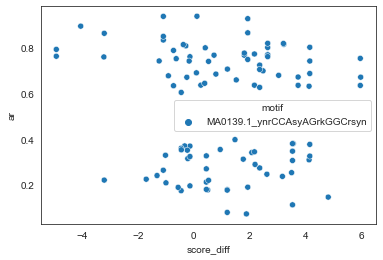

In [21]:

threshold = 4.0
plot_data = score_set[score_set.score_diff != 0.]
plot_data = plot_data[(abs(plot_data.ref_score) > threshold) | (abs(plot_data.alt_score) > threshold)]
sns.scatterplot(data=plot_data, x="score_diff", y="ar", hue="motif")

In [35]:
plot_data.alt_score.max()

3.0116625652326467

In [12]:
plot_data

,pos,strand,ref_score,alt_score,motif,ar,score_diff
9,98,-1,1.321288,3.011663,MA0139.1 CTCF_sTsA,0.697843,-1.690374
55,100,1,2.494892,3.011663,MA0139.1 CTCF_sTsA,0.709719,-0.516771
82,100,-1,1.791033,3.011663,MA0139.1 CTCF_sTsA,0.208719,-1.220630
86,97,1,1.603510,2.494892,MA0139.1 CTCF_sTsA,0.693269,-0.891382
101,100,1,1.850685,3.011663,MA0139.1 CTCF_sTsA,0.737100,-1.160977
160,97,1,1.791033,3.011663,MA0139.1 CTCF_sTsA,0.814768,-1.220630
178,99,1,0.277519,3.011663,MA0139.1 CTCF_sTsA,0.738040,-2.734144
192,100,-1,3.011663,1.791033,MA0139.1 CTCF_sTsA,0.816801,1.220630
234,97,1,1.603510,2.494892,MA0139.1 CTCF_sTsA,0.817719,-0.891382
255,100,1,1.418823,2.494892,MA0139.1 CTCF_sTsA,0.834115,-1.076069


In [51]:
def re_score(sequence, pos, strand, motif):
    length = len(motif.pfm)
    
    if strand < 0:
        motif = ~motif
    
    return motif.score_kmer(sequence[pos:pos+length])


def score_diff(set1, seq1, set2, seq2, motif: Motif):
    score1, pos1, strand1 = set1
    score2, pos2, strand2 = set2

    min_score = motif.pwm_min_score()
    max_score = motif.pwm_max_score()

    if max_score == min_score:
        return 0

    if score1 > score2:
        score2 = re_score(seq2, pos1, strand1, motif)
    else:
        score1 = re_score(seq1, pos2, strand2, motif)
    
    return (score1-score2)/(max_score-min_score)

In [60]:
ref_matches

[[[3.0116625652326467, 163, 1]],
 [[3.0116625652326467, 0, -1]],
 [[3.0116625652326467, 34, -1]],
 [[3.0116625652326467, 28, 1]],
 [[3.0116625652326467, 80, -1]],
 [[3.0116625652326467, 38, -1]],
 [[3.0116625652326467, 10, -1]],
 [[3.0116625652326467, 28, -1]],
 [[3.0116625652326467, 45, 1]],
 [[2.9308574799679983, 58, 1]],
 [[3.0116625652326467, 126, 1]],
 [[3.0116625652326467, 147, 1]],
 [[3.0116625652326467, 79, 1]],
 [[3.0116625652326467, 103, 1]],
 [[3.0116625652326467, 46, 1]],
 [[3.0116625652326467, 78, -1]],
 [[3.0116625652326467, 51, 1]],
 [[3.0116625652326467, 56, 1]],
 [[3.0116625652326467, 179, 1]],
 [[3.0116625652326467, 157, 1]],
 [[3.0116625652326467, 154, 1]],
 [[3.0116625652326467, 87, -1]],
 [[3.0116625652326467, 74, -1]],
 [[3.0116625652326467, 144, -1]],
 [[3.0116625652326467, 135, 1]],
 [[2.9308574799679983, 46, 1]],
 [[3.0116625652326467, 78, 1]],
 [[3.0116625652326467, 131, 1]],
 [[3.0116625652326467, 103, 1]],
 [[3.0116625652326467, 15, 1]],
 [[3.011662565232646

In [66]:
scores = []
for sequence in zip(ref_matches, alt_matches):
    inner = []
    for ref_set, alt_set, motif in zip(*sequence, jaspar_motifs):
         print(ref_set, alt_set, motif)
         inner.append(score_diff(ref_set, alt_set, motif))

    scores.append(inner)

[3.0116625652326467, 163, 1] [2.9308574799679983, 63, 1] MA0139.1 CTCF_sTsA
[3.0116625652326467, 0, -1] [3.0116625652326467, 0, -1] MA0139.1 CTCF_sTsA
[3.0116625652326467, 34, -1] [3.0116625652326467, 34, -1] MA0139.1 CTCF_sTsA
[3.0116625652326467, 28, 1] [3.0116625652326467, 28, 1] MA0139.1 CTCF_sTsA
[3.0116625652326467, 80, -1] [3.0116625652326467, 80, -1] MA0139.1 CTCF_sTsA
[3.0116625652326467, 38, -1] [3.0116625652326467, 38, -1] MA0139.1 CTCF_sTsA
[3.0116625652326467, 10, -1] [3.0116625652326467, 10, -1] MA0139.1 CTCF_sTsA
[3.0116625652326467, 28, -1] [3.0116625652326467, 28, -1] MA0139.1 CTCF_sTsA
[3.0116625652326467, 45, 1] [3.0116625652326467, 45, 1] MA0139.1 CTCF_sTsA
[2.9308574799679983, 58, 1] [3.0116625652326467, 98, -1] MA0139.1 CTCF_sTsA
[3.0116625652326467, 126, 1] [3.0116625652326467, 38, -1] MA0139.1 CTCF_sTsA
[3.0116625652326467, 147, 1] [2.9308574799679983, 9, 1] MA0139.1 CTCF_sTsA
[3.0116625652326467, 79, 1] [3.0116625652326467, 79, 1] MA0139.1 CTCF_sTsA
[3.01166256

In [62]:
coords = sum(map(lambda row: [(row[1], entry) for entry in row[0] if entry != 0], zip(scores, list(asb_peak_sites["Corrected.AR"]))), [])

In [63]:
scatter_coords = pd.DataFrame(coords, columns=["AR", "score"])

In [65]:
scores

[[0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0],
 [0],
 [0],
 [0.0],
 [0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0],
 [0],
 [0],
 [0.0],
 [0.0],
 [0],
 [0],
 [0.0],
 [0.0],
 [0],
 [0],
 [0.0],
 [0.0],
 [0],
 [0.0],
 [0],
 [0.0],
 [0],
 [0.0],
 [0],
 [0.0],
 [0.0],
 [0],
 [0.0],
 [0],
 [0.0],
 [0],
 [0],
 [0.0],
 [0.0],
 [0.0],
 [0],
 [0.0],
 [0.0],
 [0.0],
 [0],
 [0.0],
 [0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0],
 [0.0],
 [0.0],
 [0],
 [0.0],
 [0.0],
 [0.0],
 [0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0],
 [0.0],
 [0],
 [0.0],
 [0],
 [0.0],
 [0.0],
 [0.0],
 [0],
 [0.0],
 [0.0],
 [0],
 [0],
 [0.0],
 [0],
 [0.0],
 [0],
 [0.0],
 [0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0],
 [0],
 [0],
 [0.0],
 [0],
 [0.0],
 [0],
 [0],
 [0],
 [0.0],
 [0],
 [0.0],
 [0.0],
 [0.0],
 [0],
 [0],
 [0.0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0],
 [0.0],
 [0],
 [0.0],
 [0.0],
 [0],
 [0],
 [0.0],
 [0.0],
 [0],
 [0],
 [0],
 [

<AxesSubplot:>

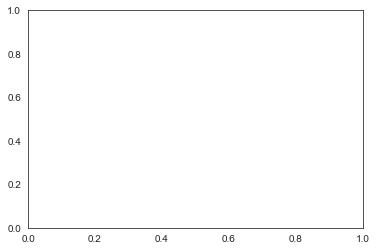

In [55]:
sns.scatterplot(data = scatter_coords, x="AR", y="score")